# **Project Overview**


This project is a risk diagnostics tool designed to evaluate and visualize the risk sensitivities (Greeks) of European-style FX options on AUD/USD, using the Black-Scholes pricing framework.

By simulating call and put options across various spot prices and expiry horizons (3M, 6M, 12M), the tool helps assess how volatility, time decay, and delta exposure evolve under changing market conditions, critical for traders managing directional and volatility risk in FX markets.


## **Key Insights from Visualization:**

**1) Vega vs Spot:**
The Vega plot indicates that AUD/USD options exhibit the highest sensitivity to implied volatility near at-the-money (ATM) strikes. As time to expiry increases, Vega values rise across the board—highlighting that long-dated options carry greater exposure to volatility risk.

**2) Theta vs Spot:**
The Theta plot reveals that short-dated options experience the most rapid time decay near ATM levels. This emphasizes the significant impact of time decay on short-term trading strategies, particularly in high-frequency trading contexts.

**3) Delta vs Spot across 3M, 6M, and 12M Tenors:**
As Days to Expiry (DTE) increases, the shape of the Delta curve evolves, reflecting changing price sensitivity structures. This illustrates the differing risk exposures between linear and nonlinear derivatives across maturities.

In [1]:
import numpy as np
import pandas as pd
from typing import Tuple
from scipy.stats import norm
from quantmod.markets import getData

# Plotting
import matplotlib.pyplot as plt
from tabulate import tabulate
import plotly.graph_objects as go

###  **Step 1: Define Black Scholes Model**

In [2]:
class BS:
    def __init__(self, spot, strike, rate, dte, volatility):
        self.S = spot
        self.K = strike
        self.r = rate
        self.t = dte
        self.sigma = volatility
        
        # Calculate common terms used across methods
        self.time_sqrt = np.sqrt(self.t)
        self.discount_factor = np.exp(-self.r * self.t)
       
        # Calculate d1 and d2 parameters
        self.d1 = self._calculate_d1()
        self.d2 = self.d1 - self.sigma * self.time_sqrt
        
        # Calculate all option Greeks and prices
        self.call_price, self.put_price = self._price()
        self.call_delta, self.put_delta = self._delta()
        self.gamma = self._gamma()
        self.vega = self._vega()
        self.call_theta, self.put_theta = self._theta()
        self.call_rho, self.put_rho = self._rho()
       
    def _calculate_d1(self) -> float:
        return (np.log(self.S / self.K) + (self.r + (self.sigma**2) / 2) * self.t) / (
            self.sigma * self.time_sqrt
        )
    
    def _price(self) -> Tuple[float, float]:
        d1_cdf = norm.cdf(self.d1)
        d2_cdf = norm.cdf(self.d2)

        call = self.S * d1_cdf - self.K * self.discount_factor * d2_cdf
        put = self.K * self.discount_factor * norm.cdf(-self.d2) - self.S * norm.cdf(
            -self.d1
        )
        return call, put
    
    def _delta(self) -> Tuple[float, float]:
        d1_cdf = norm.cdf(self.d1)
        return d1_cdf, d1_cdf - 1
    
    def _gamma(self) -> float:
        return norm.pdf(self.d1) / (self.S * self.sigma * self.time_sqrt)
    
    def _vega(self) -> float:
        return self.S * norm.pdf(self.d1) * self.time_sqrt / 100
    
    def _theta(self) -> Tuple[float, float]:
        spot_term = -self.S * norm.pdf(self.d1) * self.sigma / (2 * self.time_sqrt)
        call_rate_term = -self.r * self.K * self.discount_factor * norm.cdf(self.d2)
        put_rate_term = self.r * self.K * self.discount_factor * norm.cdf(-self.d2)

        return (spot_term + call_rate_term) / 365, (spot_term + put_rate_term) / 365
    
    def _rho(self) -> Tuple[float, float]:
        call = self.K * self.t * self.discount_factor * norm.cdf(self.d2) / 100
        put = -self.K * self.t * self.discount_factor * norm.cdf(-self.d2) / 100
        return call, put

### **Step 2: Get FX Data (AUD/USD)**

In [3]:
df = getData('AUDUSD=X', period = 'YTD')
spot = df.loc['2025-06-26', 'Close']  
spot

0.6523114442825317

### **Step 3: Simulate AUD/USD Call and Put Option for 3m, 6m, 12m**

In [4]:
strikes = np.round(np.linspace(spot * 0.95, spot * 1.05, 9), 5)
dtes = [0.25, 0.5, 1.0] 

In [5]:
# Call option 

call_results = []
for k in strikes:
    for t in dtes:
        opt = BS(spot, k, rate=0.045, dte=t, volatility=0.12)
        call_results.append({
            "Strike": k,
            "DTE": t,
            "Call Price": opt.call_price,
            "Delta": opt.call_delta,
            "Gamma": opt.gamma,
            "Vega": opt.vega,
            "Theta": opt.call_theta,
            "Rho": opt.call_rho
        })

call_results = pd.DataFrame(call_results)
print(call_results)

     Strike   DTE  Call Price     Delta      Gamma      Vega     Theta  \
0   0.61970  0.25    0.042457  0.858202   5.736310  0.000732 -0.000112   
1   0.61970  0.50    0.052059  0.819118   4.755256  0.001214 -0.000099   
2   0.61970  1.00    0.068800  0.805763   3.513811  0.001794 -0.000086   
3   0.62785  0.25    0.035879  0.803590   7.075289  0.000903 -0.000120   
4   0.62785  0.50    0.045898  0.775783   5.407724  0.001381 -0.000102   
5   0.62785  1.00    0.062924  0.774427   3.836927  0.001959 -0.000087   
6   0.63600  0.25    0.029807  0.738770   8.307737  0.001061 -0.000125   
7   0.63600  0.50    0.040124  0.727753   5.998408  0.001531 -0.000104   
8   0.63600  1.00    0.057324  0.740870   4.136628  0.002112 -0.000087   
9   0.64416  0.25    0.024307  0.665341   9.304567  0.001188 -0.000129   
10  0.64416  0.50    0.034762  0.675729   6.496476  0.001659 -0.000105   
11  0.64416  1.00    0.052005  0.705330   4.405575  0.002250 -0.000087   
12  0.65231  0.25    0.019446  0.58610

In [6]:
# put option

put_results = []
for k in strikes:
    for t in dtes:
        opt = BS(spot, k, rate=0.045, dte=t, volatility=0.12)
        put_results.append({
            "Strike": k,
            "DTE": t,
            "Put Price": opt.put_price,
            "Delta": opt.put_delta,
            "Gamma": opt.gamma,
            "Vega": opt.vega,
            "Theta": opt.put_theta,
            "Rho": opt.put_rho
        })

put_results = pd.DataFrame(put_results)
print(put_results)

     Strike   DTE  Put Price     Delta      Gamma      Vega         Theta  \
0   0.61970  0.25   0.002913 -0.141798   5.736310  0.000732 -3.638562e-05   
1   0.61970  0.50   0.005660 -0.180882   4.755256  0.001214 -2.466920e-05   
2   0.61970  1.00   0.008920 -0.194237   3.513811  0.001794 -1.277297e-05   
3   0.62785  0.25   0.004394 -0.196410   7.075289  0.000903 -4.304996e-05   
4   0.62785  0.50   0.007467 -0.224217   5.407724  0.001381 -2.643780e-05   
5   0.62785  1.00   0.010836 -0.225573   3.836927  0.001959 -1.272881e-05   
6   0.63600  0.25   0.006380 -0.261230   8.307737  0.001061 -4.793684e-05   
7   0.63600  0.50   0.009662 -0.272247   5.998408  0.001531 -2.726254e-05   
8   0.63600  1.00   0.013027 -0.259130   4.136628  0.002112 -1.227555e-05   
9   0.64416  0.25   0.008949 -0.334659   9.304567  0.001188 -5.008176e-05   
10  0.64416  0.50   0.012279 -0.324271   6.496476  0.001659 -2.693663e-05   
11  0.64416  1.00   0.015509 -0.294670   4.405575  0.002250 -1.136868e-05   

In [7]:
# Results Comparison Call & Put Option

header = ['Type', 'Option Price', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
table = [
    [
        'Call',
        call_results['Call Price'].iloc[0],
        call_results['Delta'].iloc[0],
        call_results['Gamma'].iloc[0],
        call_results['Theta'].iloc[0],
        call_results['Vega'].iloc[0],
        call_results['Rho'].iloc[0],
    ],
    [
        'Put',
        put_results['Put Price'].iloc[0],  
        -put_results['Delta'].iloc[0],       
        put_results['Gamma'].iloc[0],        
        put_results['Theta'].iloc[0],        
        put_results['Vega'].iloc[0],         
        put_results['Rho'].iloc[0],          
    ],
]

print(tabulate(table, headers=header))

Type      Option Price     Delta    Gamma         Theta         Vega           Rho
------  --------------  --------  -------  ------------  -----------  ------------
Call        0.0424573   0.858202  5.73631  -0.000111932  0.000732258   0.00129339
Put         0.00291328  0.141798  5.73631  -3.63856e-05  0.000732258  -0.000238524


### **Step 4: Greeks Sensitivity to Spot Price over Days to Expiry**

In [8]:
# Parameters Assumption 
x = np.linspace(spot * 0.95, spot * 1.05, 100)  # ±5% Volatility

d = {
    '1D': 1/252,
    '3M': 0.25,
    '6M': 0.5,
    '9M': 0.75,
    '12M': 1.0
}

rate = 0.045
vol = 0.12
strike = spot

####  1）Delta vs. Spot 

In [9]:
# Call Delta vs Spot Price

fig = go.Figure()

for label, tau in d.items():
    deltas = []
    for s in x:
        opt = BS(s, strike, rate, tau, vol)
        deltas.append(opt.call_delta)
    
    fig.add_trace(go.Scatter(
        x=x,
        y=deltas,
        mode='lines',
        name=f"{label}"
    ))

fig.update_layout(
title=dict(
    text='Call Delta vs Spot Price (AUD/USD)',
    x=0.5,
    xanchor='center',
    font=dict(size=20, family='Arial Black')
),
    xaxis_title="Spot Price",
    yaxis_title="Delta",
    template="plotly_white"
)

fig.show()

In [10]:
# Put Delta vs Spot Price

fig = go.Figure()

for label, tau in d.items():
    deltas = []
    for s in x:
        opt = BS(s, strike, rate, tau, vol)
        deltas.append(opt.put_delta)

    
    fig.add_trace(go.Scatter(
        x=x,
        y=deltas,
        mode='lines',
        name=f"{label}"
    ))

fig.update_layout(
    title=dict(
        text='Put Delta vs Spot Price (AUD/USD)',
        x=0.5,
        xanchor='center',
        font=dict(size=20, family='Arial Black')
    ),
    xaxis_title="Spot Price",
    yaxis_title="Delta",
    template="plotly_white"
)

fig.show()

#### 2）Gamma vs. Spot 

In [11]:
fig = go.Figure()

for label, tau in d.items():
    gammas = []
    for s in x:
        opt = BS(s, strike, rate, tau, vol)
        gammas.append(opt.gamma)

    fig.add_trace(go.Scatter(
        x=x,
        y=gammas,
        mode='lines',
        name=f"{label}"
    ))

fig.update_layout(
    title=dict(
        text='Gamma vs Spot Price (AUD/USD)',
        x=0.5,
        xanchor='center',
        font=dict(size=20, family='Arial Black')
    ),
    xaxis_title="Spot Price",
    yaxis_title="Gamma",
    template="plotly_white"
)

fig.show()

#### 3) Vega vs. Spot

In [12]:
fig = go.Figure()

for label, tau in d.items():
    vegas = []
    for s in x:
        opt = BS(s, strike, rate, tau, vol)
        vegas.append(opt.vega)  

    fig.add_trace(go.Scatter(
        x=x,
        y=vegas,
        mode='lines',
        name=f"{label}"
    ))

fig.update_layout(
    title=dict(
        text='Vega vs Spot Price (AUD/USD)',
        x=0.5,
        xanchor='center',
        font=dict(size=20, family='Arial Black')
    ),
    xaxis_title="Spot Price",
    yaxis_title="Vega (per 1% vol change)",
    template="plotly_white"
)

fig.show()

#### 4) Theta vs. Spot 

In [13]:
# Call Theta vs Spot Price

fig = go.Figure()

for label, tau in d.items():
    thetas = []
    for s in x:
        opt = BS(s, strike, rate, tau, vol)
        thetas.append(opt.call_theta)  # 单位是 per day

    fig.add_trace(go.Scatter(
        x=x,
        y=thetas,
        mode='lines',
        name=f"{label}"
    ))

fig.update_layout(
    title=dict(
        text='Call Theta vs Spot Price (AUD/USD)',
        x=0.5,
        xanchor='center',
        font=dict(size=20, family='Arial Black')
    ),
    xaxis_title="Spot Price",
    yaxis_title="Theta (per day)",
    template="plotly_white"
)

fig.show()

In [14]:
# Put Theta vs Spot Price

fig = go.Figure()

for label, tau in d.items():
    thetas = []
    for s in x:
        opt = BS(s, strike, rate, tau, vol)
        thetas.append(opt.put_theta)

    fig.add_trace(go.Scatter(
        x=x,
        y=thetas,
        mode='lines',
        name=f"{label}"
    ))

fig.update_layout(
    title=dict(
        text='Put Theta vs Spot Price (AUD/USD)',
        x=0.5,
        xanchor='center',
        font=dict(size=20, family='Arial Black')
    ),
    xaxis_title="Spot Price",
    yaxis_title="Theta (per day)",
    template="plotly_white"
)

fig.show()

### **Step 5: AUD/USD Option Risk Analysis**

#### 1) Call Greeks vs Spot Price

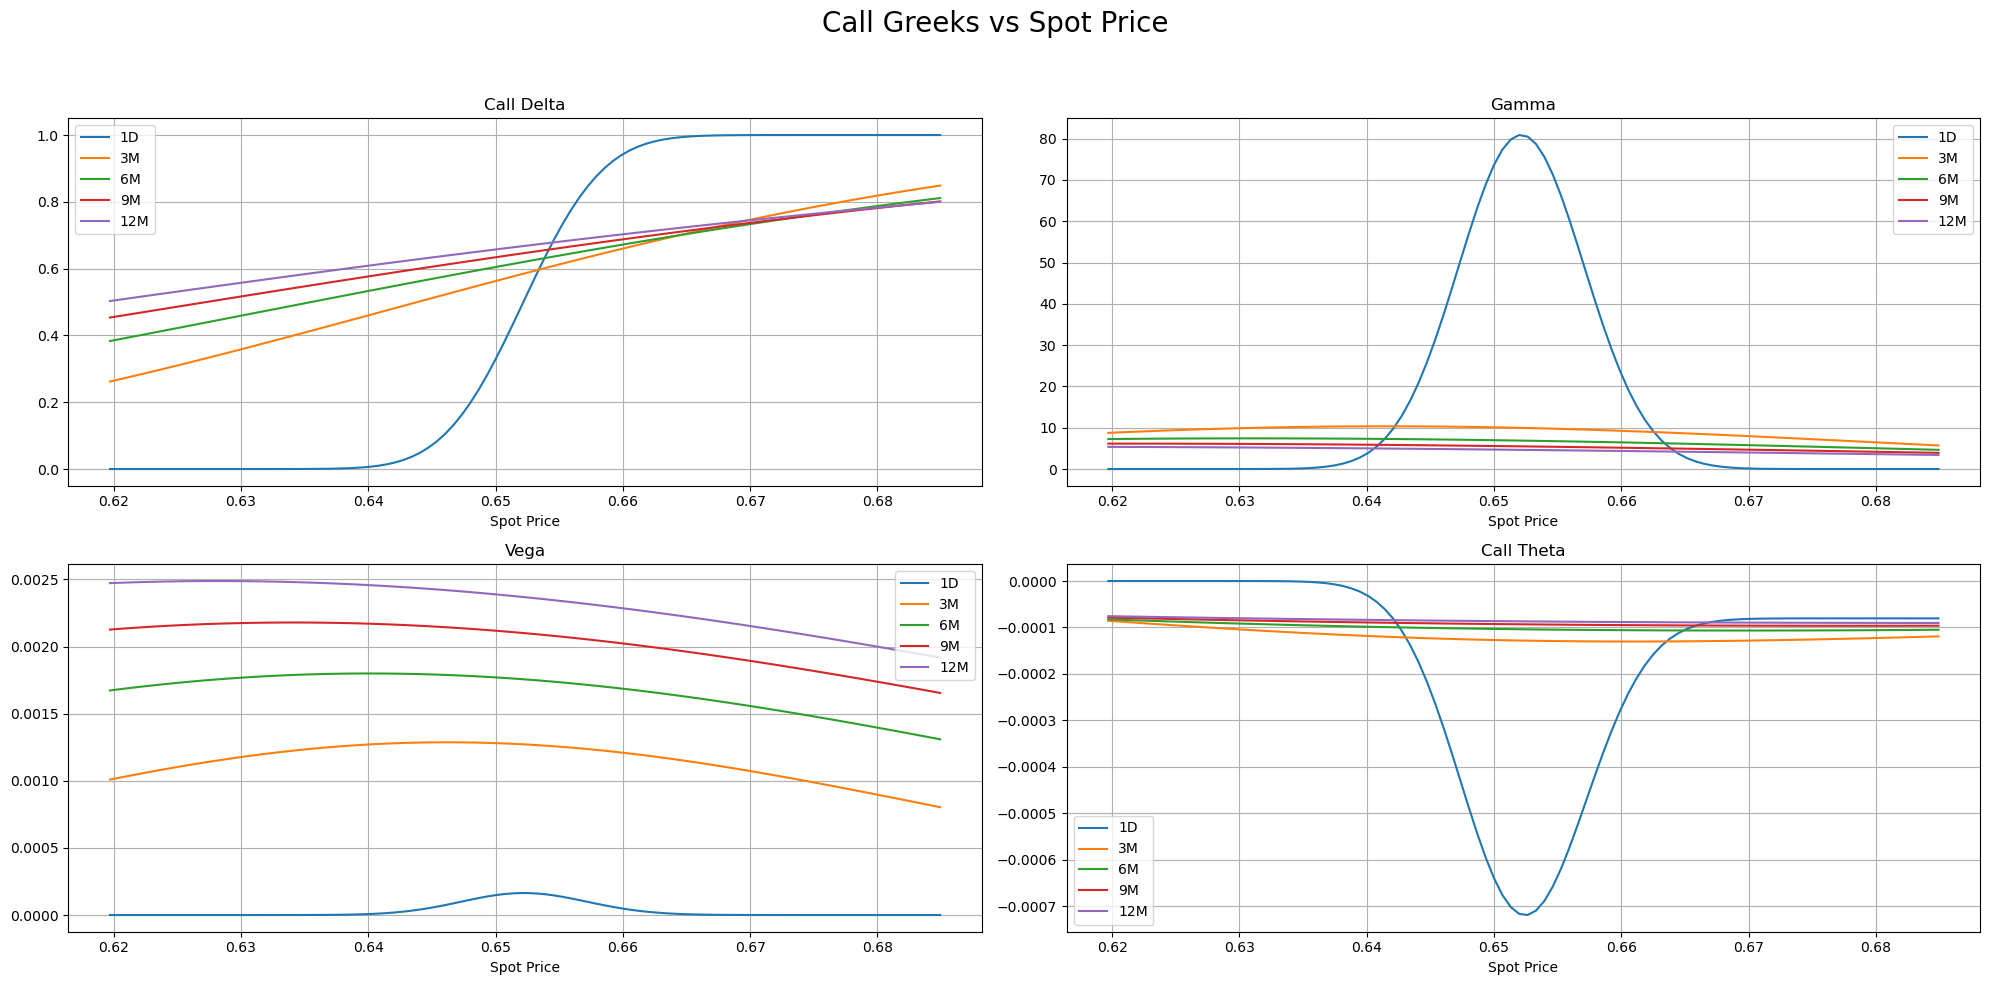

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

# Define Greeks and subplot positions
greeks = {
    (0, 0): ('call_delta', 'Call Delta'),
    (0, 1): ('gamma', 'Gamma'),
    (1, 0): ('vega', 'Vega'),
    (1, 1): ('call_theta', 'Call Theta')
}

for (i, j), (attr, title) in greeks.items():
    for label, tau in d.items():
        y_values = []  
        for s in x:
            opt = BS(s, strike, rate, tau, vol)
            y_values.append(getattr(opt, attr))  
        ax[i, j].plot(x, y_values, label=label)
        ax[i, j].set_title(title)
        ax[i, j].legend()
        ax[i, j].grid(True)
        ax[i,j].set_xlabel("Spot Price")


fig.suptitle("Call Greeks vs Spot Price", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### 2) Put Greeks vs Spot Price

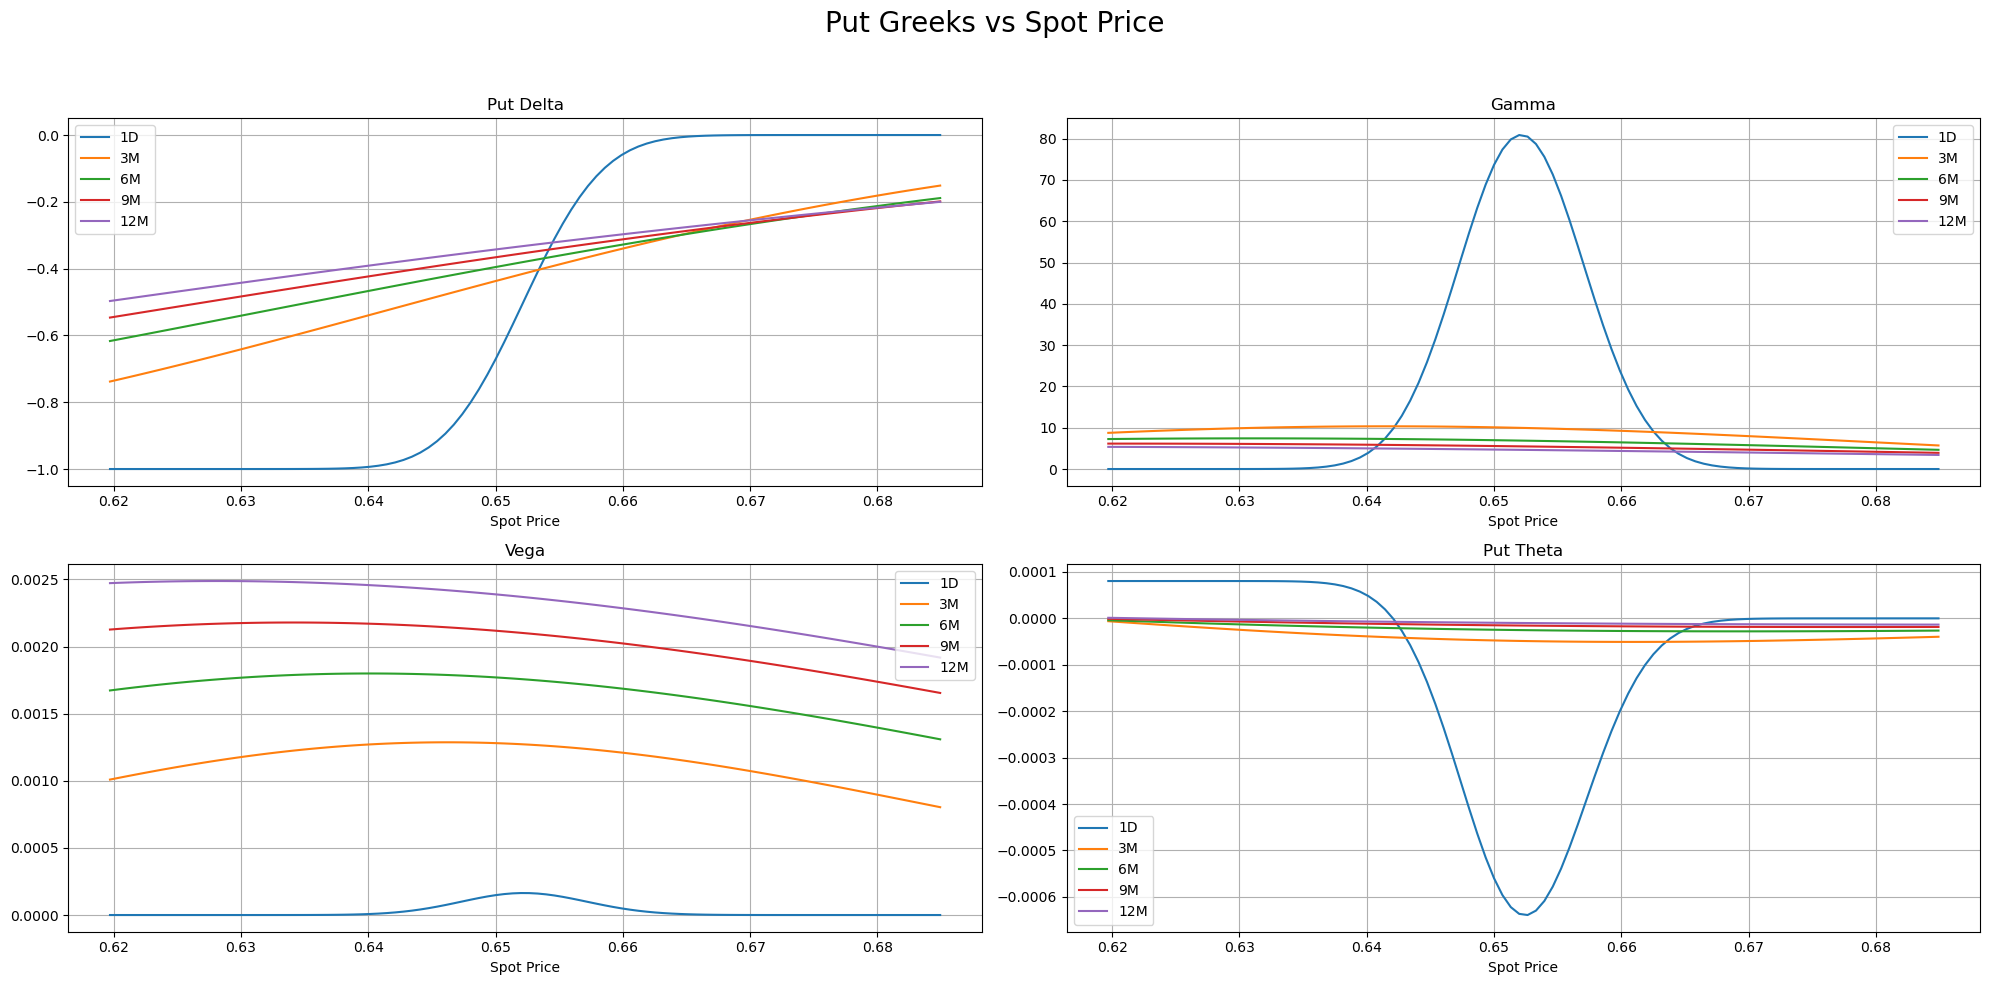

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

greeks = {
    (0, 0): ('put_delta', 'Put Delta'),
    (0, 1): ('gamma', 'Gamma'),
    (1, 0): ('vega', 'Vega'),
    (1, 1): ('put_theta', 'Put Theta')
}

for (i, j), (attr, title) in greeks.items():
    for label, tau in d.items():
        y_values = []  
        for s in x:
            opt = BS(s, strike, rate, tau, vol)
            y_values.append(getattr(opt, attr))  
        ax[i, j].plot(x, y_values, label=label)
        ax[i, j].set_title(title)
        ax[i, j].legend()
        ax[i, j].grid(True)
        ax[i,j].set_xlabel("Spot Price")

fig.suptitle("Put Greeks vs Spot Price", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()